In [1]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk import collocations
import re, string
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import sparse
from sklearn import linear_model
plt.rcParams['figure.figsize'] = [16, 6]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\geancarlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\geancarlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def getxy(row_s, row_f, feature_cols=['content', 'followers', 'following', 'retweet'], label_col=['troll']):
    return df[feature_cols][row_s:row_f], df[label_col][row_s:row_f]

In [3]:
df_trolls = pd.read_csv("dataset_troll_all.csv")
df_users = pd.read_csv("dataset_users_trial.csv")
df = pd.concat([df_trolls, df_users])

In [4]:
df.sample(5).head()

,content,followers,following,retweet,created_at,troll
96186,@Vivi_GuevaraV @forajida57 @JorgeGlas @MashiRa...,210.0,87.0,False,2019-05-06 17:55:48,True
108108,RT @ActualidadRT: Putin sobre las palabras de ...,23.0,42.0,True,2019-07-05 03:27:07,True
69284,RT @alevancor: Bastaría una resolución del CPC...,7.0,22.0,True,2019-07-06 12:12:56,True
5790,@Majindice @jfnc1966 LA CONSTITUCION LO DICE,59.0,137.0,False,2018-03-29 16:55:19,False
67230,RT @solbuendia: Los ciudadanos han sido partíc...,14.0,12.0,True,2019-07-20 03:06:47,True


In [5]:
df.shape

(191448, 6)

In [6]:
df = df.dropna()

In [7]:
df.isnull().values.any()

False

In [8]:
df['retweet'].value_counts()

True     107190
False     84251
Name: retweet, dtype: int64

In [9]:
df['troll'].value_counts()

True     166681
False     24760
Name: troll, dtype: int64

In [10]:
stopwords_set = stopwords.words('spanish')
stopwords_set.extend(stopwords.words('english'))
stopwords_set = set(stopwords_set)

In [11]:
tweets_hashtags = set([])
tweets_full_lemmas = set([])

In [12]:
def limpieza_tweet(tweets):
    # quitando icons
    tweet = tweets["content"].lower()
    sin_icons = re.sub(r'\$\w*','',tweet)
    # obteniendo palabras
    tw_Tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    temp_tweet_list = tw_Tokenizer.tokenize(sin_icons)
    # quitando urls/direcciones
    sin_https = [re.sub(r'https?:\/\/.*\/\w*|t.co\/\w*','',i) for i in temp_tweet_list]
    # quitando hashtags
    tweets_hashtags.update(sin_https)
    sin_hashtags = [re.sub(r'#|https', '', i) for i in sin_https]
    # quitando signos de puntuación
    sin_puntuacion = [re.sub(r'[' + string.punctuation + ']+', ' ', i) for i in sin_hashtags]
    sin_puntuacion = [re.sub(r'[“’—‘”–…]+', ' ', i) for i in sin_puntuacion]
    
    new_tweet = ' '.join(sin_puntuacion)
    filtrada_palabras = tw_Tokenizer.tokenize(new_tweet)
    filtrada_palabras = [re.sub(r'^\w\w?$', '', i) for i in filtrada_palabras]
    
    filtrada =' '.join(filtrada_palabras)
    tweet_final = re.sub(r'\s\s+', ' ', filtrada)
    # quitando stopwords
    tweet_final = tweet_final.strip(' ').split(' ')
    sin_stopwords = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)>1 and not i.isdigit())]
    #obteniendo los emoticones para luego analizar
    emoticones = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)==1) ]
    # obtiendo lemas
    tweets_full_lemmas.update(sin_stopwords)
    tweets["emoticones"] = ' '.join(emoticones)
    tweets["sin_stopwords"] = ' '.join(sin_stopwords)
    return tweets

In [13]:
def time_analysis(df):
    """
    Return weekday (0-6) and interval (0-3)
    """
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc = df['date']
    utc = utc.replace(tzinfo=from_zone)
    central = utc.astimezone(to_zone)
    day = central.weekday()
    hour = central.hour
    if 0 <= hour < 6:
        return day, 0
    elif 6 <= hour < 12:
        return day, 1
    elif 12 <= hour < 18:
        return day, 2
    elif 18 <= hour < 24:
        return day, 3

In [14]:
df = df.apply(limpieza_tweet, axis=1)

In [15]:
df['created_at'] = pd.to_datetime(pd.to_datetime(df['created_at']))

In [16]:
df.sample(5).head()

,content,followers,following,retweet,created_at,troll,emoticones,sin_stopwords
154304,@Davidlu37185739 @Lenin ROBOLUCION LA DECADA R...,34.0,187.0,False,2017-08-18 15:13:37,True,,robolucion decada robada
163842,RT @Richar68453806: @inapapersmoreno Sabiamos ...,18.0,62.0,True,2019-05-31 01:00:22,True,,sabiamos pillastre alta gama
108821,RT @MashiRoberto: Criminales. La historia será...,23.0,42.0,True,2019-05-30 12:32:48,True,,criminales historia despiadada
98726,RT @luly_alban: Jaja jajaja; me voy a reir ha...,803.0,516.0,True,2019-07-07 20:01:38,True,,jaja jajaja voy reir caigan muelas còmo tarzàn...
118566,RT @MashiRafael: Murió a los 73 años Corona Av...,338.0,88.0,True,2019-06-26 01:40:47,True,,murió años corona aveiga zambrano madre cinthy...


In [17]:
texto = df["sin_stopwords"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
palabras = nltk.tokenize.word_tokenize(texto, language="spanish")
distribucion = nltk.FreqDist(palabras)
frecuencia = pd.DataFrame(distribucion.most_common(20),columns=['Palabra', 'Frequencia']).set_index('Palabra')

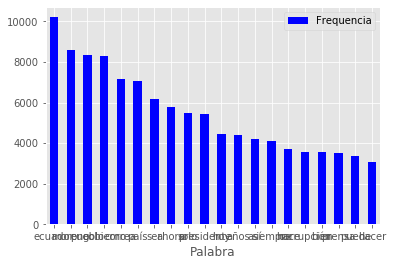

In [20]:
matplotlib.style.use('ggplot')
frecuencia.plot.bar(rot=0, color="blue")

In [21]:
df = df.sample(frac=1)

In [22]:
X_train, y_train = getxy(0,190000)

In [23]:
X_test, y_test = getxy(190001,191448)

In [24]:
X_train.shape, y_train.shape

((190000, 4), (190000, 1))

In [25]:
X_test.shape, y_test.shape

((1440, 4), (1440, 1))

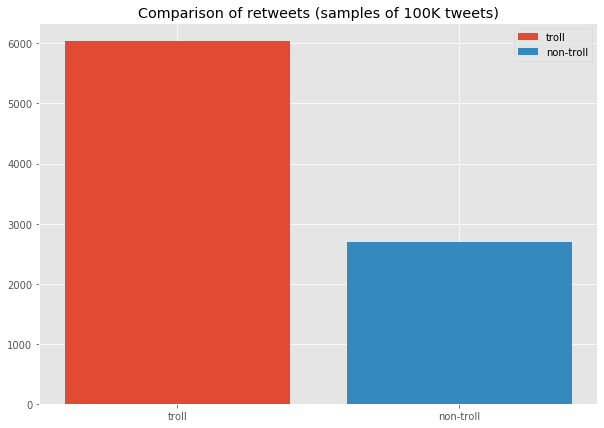

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Comparison of retweets (samples of 100K tweets)')

troll_retweets = np.sum(df_trolls['retweet'].sample(10000))
nontroll_retweets = np.sum(df_users['retweet'].sample(10000))

ax.bar(['troll'],troll_retweets,label='troll')
ax.bar(['non-troll'],nontroll_retweets,label='non-troll')

ax.legend()
plt.show()


### Tokenize words

In [27]:
vocab_size=5000
tokenizer=feature_extraction.text.CountVectorizer(stop_words=stopwords_set, max_features=vocab_size)
tokenizer=tokenizer.fit(df['sin_stopwords'])

In [28]:
X_train_tok=tokenizer.transform(X_train['content'])
X_test_tok=tokenizer.transform(X_test['content'])

### Standarize followers/following

In [29]:
scaler = preprocessing.StandardScaler().fit(X_train[['followers','following']])

In [30]:
'rand means and scales: {}, {}'.format(scaler.mean_, scaler.scale_)

'rand means and scales: [415.71665789 418.20685789], [1438.81601929  754.11459929]'

In [31]:
col_to_std = ['followers', 'following']
X_train[col_to_std]=scaler.transform(X_train[col_to_std])
X_test[col_to_std]=scaler.transform(X_test[col_to_std])

In [32]:
X_train[col_to_std].head()

,followers,following
837,0.364385,1.594974
90514,0.821706,2.646538
81582,-0.259739,-0.410026
3149,-0.028299,0.739666
14641,0.269168,0.129679


### Binarize outcome

In [33]:
y_train.head()

,troll
837,False
90514,True
81582,True
3149,False
14641,True


In [34]:
bool_to_bin = lambda x: 1 if x else 0
y_train['troll'] = y_train['troll'].apply(bool_to_bin)
y_test['troll'] = y_test['troll'].apply(bool_to_bin)

# binarize retweet colum
X_train['retweet'] = X_train['retweet'].apply(bool_to_bin)
X_test['retweet'] = X_test['retweet'].apply(bool_to_bin)

### Concatenate features

In [35]:
def concatenate_features(tok_matrix, data_df):
    """ concatenate the tokenized matrix (scipy.sparse) with other features """
    sparse_cols = sparse.csr_matrix(data_df[['followers', 'following', 'retweet']])
    combined = sparse.hstack([tok_matrix, sparse_cols])
    return combined

In [36]:
X_train_combined = concatenate_features(X_train_tok, X_train)
X_test_combined = concatenate_features(X_test_tok, X_test)

In [37]:
X_train_combined.shape

(190000, 5003)

## Training the model - Logistic Regresion

In [38]:
logic_model = linear_model.LogisticRegression().fit(X_train_combined, y_train['troll'])

C:\Users\geancarlo\Anaconda3\envs\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
logic_model.score(X_train_combined, y_train['troll'])

0.9166736842105263

In [40]:
logic_model.score(X_test_combined, y_test['troll'])

0.9111111111111111

## Creating Neural Net

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

In [45]:
X_train_combined.shape[1:]

(5003,)

In [49]:
model = Sequential()  # 5003 inputs
model.add(Dense(1024, activation='relu', input_shape=X_train_combined.shape[1:])) # first layer
model.add(Dropout(0.7))
model.add(Dense(512, activation='relu'))  # second layer 1024 inputs
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))  # third layer  512 inputs
model.add(Dense(1, activation='sigmoid'))  # last layer

W0819 00:30:52.243973 15432 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 00:30:52.306926 15432 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              5124096   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 5,714,689
Trainable params: 5,714,689
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0819 00:39:13.504557 15432 deprecation_wrapper.py:119] From C:\Users\geancarlo\Anaconda3\envs\venv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 00:39:13.536527 15432 deprecation_wrapper.py:119] From C:\Users\geancarlo\Anaconda3\envs\venv\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0819 00:39:13.550520 15432 deprecation.py:323] From C:\Users\geancarlo\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [64]:
# converting test scipy.sparse matrix to numpy
X_test_matrix = X_test_combined.todense()
X_train_matrix = X_train_combined.todense()

In [63]:
score = model.evaluate(X_test_matrix, y_test['troll'], verbose=0)
accuracy = 100*score[1]

print('Precisión en el conjunto de prueba: %.4f%%' % accuracy)

Precisión en el conjunto de prueba: 59.8611%


In [65]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='trolls.model.best.hdf5', verbose=1, save_best_only=True)
hist = model.fit(X_train_matrix, y_train['troll'], batch_size=1024, epochs=20, validation_split=0.2, callbacks=[checkpointer], verbose=1, shuffle=True)

Train on 152000 samples, validate on 38000 samples
Epoch 1/20
152000/152000 [==============================] - 130s 853us/step - loss: 0.2891 - acc: 0.8829 - val_loss: 0.2088 - val_acc: 0.9153

Epoch 00001: val_loss improved from inf to 0.20884, saving model to trolls.model.best.hdf5
Epoch 2/20
152000/152000 [==============================] - 140s 919us/step - loss: 0.1855 - acc: 0.9231 - val_loss: 0.1753 - val_acc: 0.9256

Epoch 00002: val_loss improved from 0.20884 to 0.17526, saving model to trolls.model.best.hdf5
Epoch 3/20
152000/152000 [==============================] - 121s 794us/step - loss: 0.1438 - acc: 0.9386 - val_loss: 0.1716 - val_acc: 0.9302

Epoch 00003: val_loss improved from 0.17526 to 0.17155, saving model to trolls.model.best.hdf5
Epoch 4/20
152000/152000 [==============================] - 114s 750us/step - loss: 0.1142 - acc: 0.9516 - val_loss: 0.1777 - val_acc: 0.9292

Epoch 00004: val_loss did not improve from 0.17155
Epoch 5/20
152000/152000 [===================

In [67]:
model.load_weights('trolls.model.best.hdf5')
score = model.evaluate(X_test_matrix, y_test['troll'], verbose=0)
accuracy = 100*score[1]

# mostrar la precisión en prubea
print('Precisión durante la prueba: %.4f%%' % accuracy)

Precisión durante la prueba: 93.1944%
